# 新闻言论自动提取
步骤：
1. 构建word2vec词向量模型(可用维基百科数据)利用搜索方法找出和说等相关的词，然后进行筛选，保存到文件备用
2. 把步骤1的词向量模型对象的向量数据保存(model.wv类保存成.kv文件)，后续计算句子相似度用，备用
3. 利用pyltp等库对输入新闻进行解析，获取详细依存关系等
4. 利用3种获得数据进行分析，找出说话的人和他说的话
5. 如果4中找出了某人说的话，用该句话和后几个句子(实际调整)进行句子向量化分析，判断后面句子和该句话的相似度，当大于某个阈值时，认为后面句子也是说话的内容。以此来判断说话截止
6. 搭建相应前后端框架，最后利用web框架展示成果

## 步骤1-2实现代码
word2vec模型构建在这不做讲解，仅实现下如何搜索相关词

In [1]:
from gensim.models import KeyedVectors
from collections import defaultdict
import time
def get_related_words_im(initial_words, model):
    """
    @initial_words are initial words we already know. is a list input
    @model is the word2vec model, better be model vectors , more fast for search
    """
    unseen = initial_words
    seen = defaultdict(int)
    
    max_size = 200  # could be greater
 
    current_layer = 0
    current_layer_length = len(unseen)
    current_length = len(initial_words)  
    
    total_most_similar_find_time = 0
    cache_dict = defaultdict(list)  #添加缓存，防止重复调用most_similar，因为调用most_similar费时间
    while unseen and len(seen) < max_size:
        if len(seen) % 50 == 0: 
            print('seen length : {}'.format(len(seen)))
            
        #print(unseen)          
        node = unseen.pop(0)#类似广度搜索
        
        current_length -= 1        
        if node in cache_dict:
            new_expanding = cache_dict[node]
        else:
            time_point = time.time()
            new_expanding = [w for w, s in model.most_similar(node, topn=20)]
            cache_dict[node] = new_expanding
            total_most_similar_find_time += time.time()- time_point 
          
        unseen += new_expanding      
        #当前层数遍历完，说明此时的unseen里保存的是下一层所有结点,更新层数和下一层结点个数
        if current_length ==0: 
            current_layer += 1
            current_layer_length = len(unseen)
            current_length  = len(unseen)    
        
        #if seen['说']== 2:
        #    break    
        # node 节点的权值，可以在这里考虑优化搜索效果
        seen[node] +=  (1 - current_layer*0.1) * ((current_length/current_layer_length)*0.2 + 0.8)
        
        # optimal: 1. score function could be revised
        # optimal: 2. using dymanic programming to reduce computing time
    total_most_similar_find_time = int(total_most_similar_find_time)
    print(current_layer)
    print('total_most_similar_find_time:{}min {}s'.\
          format(total_most_similar_find_time//60 ,total_most_similar_find_time%60))
    return seen

D:\Design Software\Anaconda\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
fname = r"E:/MYGIT/model/wiki_stopwords/wiki_word2vec.kv"
model_wv = KeyedVectors.load(fname, mmap='r')

D:\Design Software\Anaconda\envs\py36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
%%time
related_words  = get_related_words_im(['说', '表示'], model_wv)
result_sorted = sorted(related_words.items(), key=lambda x: x[1], reverse=True)

seen length : 0
seen length : 50
seen length : 100
seen length : 150
seen length : 150
seen length : 150
2
total_most_similar_find_time:2min 10s
Wall time: 2min 10s


In [4]:
result_sorted[:5]

[('说', 7.1913),
 ('认为', 4.8077000000000005),
 ('表示', 4.1393),
 ('指出', 4.0452),
 ('称', 4.0292)]

想要本文提取中获得更好的效果，我们需要人为地在以上搜索结果中进行筛选剔除(总会有一些词不是我们想要的)。然后把结果保存至文件备用

## 步骤3-4实现代码

In [5]:
from collections import defaultdict
from pyltp import Segmentor
from pyltp import Postagger
from pyltp import NamedEntityRecognizer
from pyltp import SentenceSplitter
from pyltp import Parser
from gensim.models import KeyedVectors
import numpy as np
import jieba
import os
import re
import time
from collections import Counter

def get_sentences_vec(model_wv, sent_list, word_frequence):
    # 句子向量化处理
    a = 0.001
    row = model_wv.vector_size
    col = len(sent_list)
    sent_mat = np.zeros((row, col))
    for i, sent in enumerate(sent_list):
        length = len(sent)
        sent_vec = np.zeros(row)
        for word in sent:
            pw = word_frequence[word]
            w = a / (a + pw)
            try:
                vec = np.array(model_wv[word])
                sent_vec += w * vec
            except:
                pass
        sent_mat[:, i] += sent_vec
        sent_mat[:, i] /= length

    # PCA处理
    sent_mat = np.mat(sent_mat)
    u, s, vh = np.linalg.svd(sent_mat)
    sent_mat = sent_mat - u * u.T * sent_mat
    return sent_mat

def get_word_frequence(words):
    #这里不做停用次处理，直接在计算句子向量时候，如果找不到该词，直接跳过
    word_list = []
    for word in words:
        word_list += word
    word_frequence = Counter(word_list)
    return word_frequence

# 计算余弦相似度
def cos_similarity(v1, v2):
    #输入向量维度不一致
    if len(v1) != len(v2):
        return 0
    return np.vdot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 返回句子向量矩阵中各列向量与第一列向量的相似度
def calcu_similarity(sent_mat):
    #采用点积的方法计算
    first = np.array(sent_mat[:, 0]).flatten()
    col = sent_mat.shape[1]
    sims = []
    for i in range(1, col):
        vec = np.array(sent_mat[:, i]).flatten()
        sims.append(cos_similarity(first, vec))
    return sims

#获取相似度结果
def get_similarity_result(word_list_all, model_wv):
    word_frequence = get_word_frequence(word_list_all)
    sent_mat = get_sentences_vec(model_wv, word_list_all,word_frequence)
    sim = calcu_similarity(sent_mat)
    return sim


#分句
def cut_sentence(string):
    """@string contain many sentence"""
    from pyltp import SentenceSplitter
    sents = SentenceSplitter.split(string)  # 分句
    return list(sents)

#加载模型
def load_all_model():
    """返回分词，词性标注，命名实体识别，依存解析等实例对象"""
    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    cws_model_path = os.path.join(LTP_DATA_DIR, 'cws.model')  # 分词模型路径，模型名称为`cws.model`
    segmentor = Segmentor()  # 初始化实例
    segmentor.load_with_lexicon(cws_model_path, '../ltp_data/cut_external_dict/cut_external_dict')  # 加载模型
    
    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    pos_model_path = os.path.join(LTP_DATA_DIR, 'pos.model')  # 词性标注模型路径，模型名称为`pos.model`
    postagger = Postagger() # 初始化实例
    postagger.load_with_lexicon(pos_model_path, '../ltp_data/pos_external_dict/pos_external_dict')  # 加载模型

    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    ner_model_path = os.path.join(LTP_DATA_DIR, 'ner.model')  # 命名实体识别模型路径，模型名称为`pos.model`
    recognizer = NamedEntityRecognizer() # 初始化实例
    recognizer.load(ner_model_path)  # 加载模型

    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    par_model_path = os.path.join(LTP_DATA_DIR, 'parser.model')  # 依存句法分析模型路径，模型名称为`parser.model`   
    parser = Parser() # 初始化实例
    parser.load(par_model_path)  # 加载模型
    
    fname = r"E:/MYGIT/model/wiki_stopwords/wiki_word2vec.kv"
    #model_wv.save(fname)
    model_wv = KeyedVectors.load(fname, mmap='r')
    return [segmentor, postagger, recognizer, parser,model_wv]

#释放模型
def release_all_model(model_list):
    del(model_list[-1])
    for each in model_list:
        each.release()

#获取人名或机构名
def get_name(word_list, prase, ner_list, pos_list,say_index):
    # 合并说话对象名字
    index = -1
    for arc in prase:
        if arc.relation == "SBV" and arc.head == say_index+1:
            index = prase.index(arc)
            break  
    #第二种情况
    if index == -1:
        for arc in prase:
            if arc.relation == "SBV" and arc.head == prase[say_index].head and prase[say_index].relation =="COO":
                index = prase.index(arc)
    #两种情况都没找到
    if index == -1:return ''
    
    Entity = ['S-Nh', 'S-Ni', 'B-Nh', 'B-Ni', 'I-Nh', 'I-Ni', 'E-Nh', 'E-Ni']  # 命名实体标记
    name = word_list[index]
    
    if ner_list[index] in Entity: return name
    if pos_list[index] not in ['n', 'nh']:return ''
    
    pre=word_list[:index]#前半部分
    pos=word_list[index+1:]#后半部分
    while pre:
        w = pre.pop(-1)
        w_index = word_list.index(w)

        if prase[w_index].relation == 'ADV': continue
        if prase[w_index].relation in ['WP', 'ATT', 'SVB'] and (w not in ['，','。','、','）','（']):
            name = w + name
        else:
            pre = False          
    while pos:
        w = pos.pop(0)
        w_index = word_list.index(w)
        if prase[w_index].relation in ['WP', 'LAD', 'COO', 'RAD'] and w_index < say_index and (w not in ['，', '。', '、', '）', '（']):
            name = name + w # 向后拼接
        else: #中断拼接直接返回
            pos = False
    return name   
 
def get_under_node(parent_node, parse, relation):
    index = []
    for arc in parse:
        if arc.relation == relation and arc.head == parent_node +1:
            index.append(parse.index(arc))
    try:
        return index
    except NameError:
        return -1 
    
#找出输入所有节点中最小的索引和最大的索引，然后返回两者间的句子
def node_under_sentence(parent_point, den_parsing_list, word_list):    
    words_index = []
    #搜索子节点
    if parent_point == [] or parent_point[0] < 0 :return ''
    for point in parent_point:
        start = [point]
        words_index.append(start[0])
        while start!= []:
            cur = start.pop(0)
            for i, arc in enumerate(den_parsing_list):
                if arc.head == cur + 1:
                    words_index.append(i)
                    start.append(i)
    words_index = sorted(words_index)
    #print(words_index, len(word_list))
    return ''.join(word_list[words_index[0]:words_index[-1]+1])

#从文件中提取与说相关的词
def get_relatedwords():
    path  = 'E:/MYGIT/Project/NLP-Project-1/related_words/saywords'
    relatedwords_list = []
    with open(path, encoding='utf-8') as f:
        line_str= f.readline()
        while line_str  != '':
            relatedwords_list.append(line_str.strip('\n'))
            line_str = f.readline()
    relatedwords_list = tuple(relatedwords_list)
    return relatedwords_list

def find_opinion_of_someone(input_news, say_related, model_list):
    # 输入文本进行分句
    segmentor = model_list[0]
    postagger = model_list[1]
    recognizer= model_list[2]
    parser= model_list[3]
    model_wv = model_list[4]

    sentence_list = cut_sentence(input_news)
    sentence_list = [sen for sen in sentence_list if len(sen) > 3]
    Entity = ['S-Nh', 'S-Ni', 'B-Nh', 'B-Ni', 'I-Nh', 'I-Ni', 'E-Nh', 'E-Ni']  # 命名实体标记
    pro_news_dict = defaultdict(list) #用来存储可能是多句的句子
    news_dict = defaultdict(list)
    
    word_list_all = [list(segmentor.segment(sentence)) for sentence in sentence_list]  # 分词
    #name_list = [] #用于保存所有人名
    for _i, sentence in enumerate(sentence_list):
        #print('\n——————————句子:{} 处理过程——————————'.format(_i + 1))
        #time_point_1 = time.time()
        word_list = word_list_all[_i]  #     
        pos_list = list(postagger.postag(word_list))  # 词性分析
        ner_list = list(recognizer.recognize(word_list, pos_list))  # 命名实体提取
        den_parsing_list = list(parser.parse(word_list, pos_list))  # 依存关系
                        
        # 获取命名实体和说相关词,同时获取索引值
        pro_say_word = [(a, i) for i, a in enumerate(word_list) if a in say_related]  
        if pro_say_word==[]:continue
        
        # 找到说的主语
        for say in pro_say_word:
            name = get_name(word_list, den_parsing_list, ner_list, pos_list, say[1])
            #print('第{}句子, sayword:{} name:{}'.format(_i, say, name))
            if name != '':
                say_underword = []
                index = get_under_node(say[1], den_parsing_list, 'VOB')           
                if index != -1: 
                    _flag = len(index)
                    say_underword += index
                    index = get_under_node(say[1], den_parsing_list, 'COO')
                    if index != -1: say_underword += index
                        
                #特殊情况处理1
                if len(say_underword) > _flag:
                    for _node in range(_flag):
                        if pos_list[say_underword[_node]] in ['n','nh']:
                            say_underword.pop(0)
                
                #特殊情况处理2
                saying = node_under_sentence(say_underword, den_parsing_list, word_list)
                if not saying:
                    if (den_parsing_list[say[1]].relation =='POB' and den_parsing_list[den_parsing_list[say[1]].head-1].relation == 'ADV'):
                        saying = ''.join(word_list[say[1]+1:])
                        saying = saying.strip('，')
                    if not saying:
                        if _i>0:
                            quotations = re.findall(r'“(.+?)”', sentence_list[_i-1])
                            if quotations and len(quotations[-1])> 6: saying = quotations[-1]
                if saying != '':
                    if saying[-5:] in sentence[-9:]:
                        words1 = jieba.lcut(saying)
                        _word_list = sentence_list[_i+1:_i+4] #切片的话_i+4如果超出则取到末尾
                        _word_list.insert(0, words1)
                        sim = get_similarity_result(_word_list, model_wv)
                        #print(sim)
                        for i_sim, _sim in enumerate(sim):
                            if _sim > 0.85:
                                pro_news_dict[_i] += [sentence_list[_i + i_sim+1]]
                            else:
                                break
                    news_dict[_i] = [name, saying]
                    break  
    
    #对多句添加进行判断，如果下一句里没说，或没提取出来，则拼接到上一句，避免重复
    for key in pro_news_dict.keys():
        for _i in range(len(pro_news_dict[key])):
            if key+_i+1 not in news_dict.keys():
                news_dict[key][1] += pro_news_dict[key][_i]
            else:
                break 
    return news_dict

## 步骤5原理与实现代码

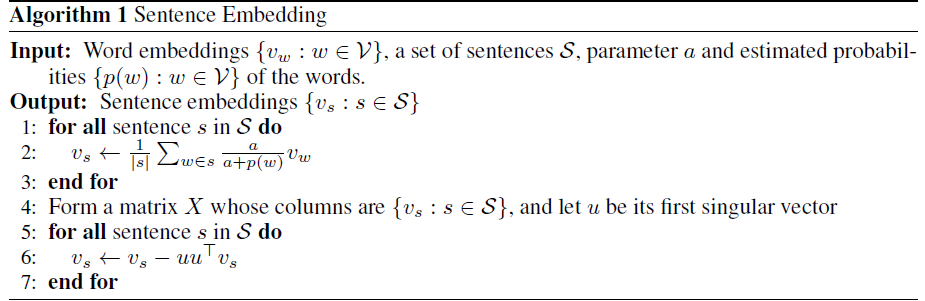

[句子向量化论文参考](https://openreview.net/pdf?id=SyK00v5xx)
- line2：计算每条句子的向量，以列存储 原文是 compute the weighted average of the word vector
- line6：原文是 remove the projections of the average vectors on their first singular verctor(common component removal),至于为什么line6这样计算会是common component removal，还没弄明白，有空再深究
- 最后得到的矩阵是M×N的 M为词向量维度，N为句子个数，可以看出每个句子向量都是以列保存的

In [6]:
from gensim.models import KeyedVectors
import logging

#该函数对应的是上诉图片中伪代码的实现过程
def get_sentences_vec(model_wv, sent_list, word_frequence):
    # 句子向量化处理
    a = 0.001
    row = model_wv.vector_size
    col = len(sent_list)
    sent_mat = np.zeros((row, col))
    for i, sent in enumerate(sent_list):
        length = len(sent)
        sent_vec = np.zeros(row)
        for word in sent:
            pw = word_frequence[word]
            w = a / (a + pw)
            try:
                vec = np.array(model_wv[word])
                sent_vec += w * vec
            except:
                pass
        sent_mat[:, i] += sent_vec
        sent_mat[:, i] /= length

    # PCA处理
    sent_mat = np.mat(sent_mat)
    u, s, vh = np.linalg.svd(sent_mat)
    sent_mat = sent_mat - u * u.T * sent_mat
    return sent_mat

def get_word_frequence(words):
    #这里不做停用次处理，直接在计算句子向量时候，如果找不到该词，直接跳过
    word_list = []
    for word in words:
        word_list += word
    word_frequence = Counter(word_list)
    return word_frequence

# 计算余弦相似度
def cos_similarity(v1, v2):
    #输入向量维度不一致
    if len(v1) != len(v2):
        return 0
    return np.vdot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 返回句子向量矩阵中各列向量与第一列向量的相似度
def calcu_similarity(sent_mat):
    #采用点积的方法计算
    first = np.array(sent_mat[:, 0]).flatten()
    col = sent_mat.shape[1]
    sims = []
    for i in range(1, col):
        vec = np.array(sent_mat[:, i]).flatten()
        sims.append(cos_similarity(first, vec))
    return sims

#获取相似度结果，相当于封装以上几个函数，简化调用
def get_similarity_result(word_list_all, model_wv):
    word_frequence = get_word_frequence(word_list_all)
    sent_mat = get_sentences_vec(model_wv, word_list_all,word_frequence)
    sim = calcu_similarity(sent_mat)
    return sim

## 模型效果测试

In [7]:
input_news = '''中国国务院新闻办公室当日举行“建设国家公园省 传递大美青海情”发布会。刘宁说，时至今日，青海绝不是仅仅保护一两种动物。现在三江源区有蹄类的动物已经恢复到18万只。青海有603种动物属种，有了大面积恢复，生产力、生长力在不断增强。
　　青海有中国最大的世界自然遗产地可可西里，它在4500米的高原上，有6.03万平方公里，是三江源国家公园重要的组成部分。可可西里有一个卓乃湖，是藏羚羊的栖息地、繁育地。刘宁特别提到了为了保护藏羚羊不被非法猎取而牺牲生命的索南达杰。
　　“最近我们遇到了难题。”刘宁说，由于生态恢复、植被恢复和降雨量的增加，还有局部气温升高，导致卓乃湖降雨量丰沛，与其他三个湖连起来，一旦漫溢可能冲刷掉下游大量的沼泽、湿地和冻土，甚至对沿途经过的青藏铁路、青藏公路、输电线路等带来影响。今年7月15日青海开始应急工程施工，1800多人和500多台机械在4500米的高原上紧急作业，到8月25日开始放水，现在险情总体可控。
　　刘宁通过这个例子说，在顺应自然、尊重自然的同时，保护自然绝不是盲目等待自然的演替，而是在人力可能干预的情况下，对于自然灾害可能造成的破坏，进行积极主动的保护。
　　他同时表示，青海和西藏的羌塘、新疆的阿尔金山是联动的。如果出现了对二级保护动物、一级保护动物带来的伤害，都要互相协同追责。
　　刘宁说，在青海有一个阿尼玛卿雪山是小冰川时代的遗址，山里有360个湖泊，最高峰是5369米，现在出于保护的原因被关闭了。青海湖还有一个鸟岛，有几千种候鸟，现在也进行了有效的管理。
　　“但是管理不代表完全封闭。将来随着发展，生态旅游一定会在国家公园里发展起来。”刘宁表示，相信通过这样的体制建设，会把管理和自然生态需求紧密联结在一起，把责任的边界和保护的价值、开发的潜力紧密协同起来。'''

In [8]:
model_list = load_all_model() #加载模型
say_related = get_relatedwords() #获取步骤2保存的搜索结果
find_opinion_of_someone(input_news, say_related, model_list)#进行提取

D:\Design Software\Anaconda\envs\py36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Oliver\AppData\Local\Temp\jieba.cache
Loading model cost 0.889 seconds.
Prefix dict has been built succesfully.


defaultdict(list,
            {1: ['刘宁', '时至今日，青海绝不是仅仅保护一两种动物'],
             6: ['刘宁', '为了保护藏羚羊不被非法猎取而牺牲生命的索南达杰'],
             8: ['刘宁',
              '由于生态恢复、植被恢复和降雨量的增加，还有局部气温升高，导致卓乃湖降雨量丰沛，与其他三个湖连起来，一旦漫溢可能冲刷掉下游大量的沼泽、湿地和冻土，甚至对沿途经过的青藏铁路、青藏公路、输电线路等带来影响'],
             10: ['刘宁',
              '在顺应自然、尊重自然的同时，保护自然绝不是盲目等待自然的演替，而是在人力可能干预的情况下，对于自然灾害可能造成的破坏，进行积极主动的保护'],
             11: ['他', '青海和西藏的羌塘、新疆的阿尔金山是联动的'],
             13: ['刘宁',
              '在青海有一个阿尼玛卿雪山是小冰川时代的遗址，山里有360个湖泊，最高峰是5369米，现在出于保护的原因被关闭了'],
             17: ['刘宁',
              '相信通过这样的体制建设，会把管理和自然生态需求紧密联结在一起，把责任的边界和保护的价值、开发的潜力紧密协同起来']})

## 步骤6展示

<video src="./media/web_show.mp4" controls="controls" width="500" height="300">您的浏览器不支持播放该视频！</video>

# 总结

1. 模型实现句子向量化对判断两条句子的相似度效果不错，可以根据设定相似度阈值来进行筛选
2. 模型的人名提取还存在一定缺陷，有时候提取到的人名过长，比如**隔壁家的老奶奶**，这里实现全部提取，而不是只提取老奶奶。可根据实际情况调整。
3. 对于一些特殊的句子，模型还暂时提取不出来，可根据具体实际要求，来增加相应的规则。可以直接在代码里面增加，而不用从写。
4. 对于一些更特殊的情况，可以考虑在pyltp模型载入时，增加自定义的字典。达到切词，分词等想要的结果。这点可根据实际情况优化
5. 由于pyltp等模型加载大概要花费10s时间并且所占据内存过大，故在实际项目中，需要考虑预加载问题和释放问题和并发问题
6. 对于web前端框架可以继续优化美观，由于作者不是专业前端人员，该项目前端都是现学现卖的。
---